## Circuit Noise Simulations

In order to benchmark measurement protocol, it is useful to be able to simulate quantum circuits using tensor-network methods. This can be done either using density-matrix or quantum trajectory methods, see for instance [Daniel Jaschke et al 2019 Quantum Sci. Technol. 4 013001](https://iopscience.iop.org/article/10.1088/2058-9565/aae724)

In [1]:
using Revise
using ITensors
using ProgressMeter
using RandomMeas

We first consider a random circuit wavefunction $\psi$ of depth $d=2 steps$, by successive application of depth 2 random circuits. 

In [2]:

N = 40
steps = 3
ξ = siteinds("Qubit", N)
states = ["Dn" for n in 1:N]
cutoff = 1e-4
ψ0 = MPS(ξ,states);
ψ = MPS[]
push!(ψ,ψ0)
circuit_layer = Vector{Vector{ITensor}}()
@showprogress dt=1 for d in 1:steps
        push!(circuit_layer,random_circuit(ξ,2))
        push!(ψ,apply(circuit_layer[d],ψ[d];cutoff=cutoff))
end
println("State prepared")
println("with bond dimension (pure state) ", maxlinkdim(ψ[steps]))


Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


State prepared
with bond dimension (pure state) 13


In order to simulate the corresponding experimental state in presence of noise, we consider the local depolarization channel to form a mixed state $\rho$

This can be implemented by apply directly the channel on an MPO $\rho$ that is returned from the ITensor function *apply*

In [3]:
ρ = outer(ψ0',ψ0);
p = 0.05*rand(N)
Fidelity = zeros(Float64,steps)
@showprogress dt=1 for d in 1:steps
            ρ = apply(circuit_layer[d],ρ,apply_dag=true;cutoff=cutoff)
            ρ = apply_depo_channel(ρ,p)
            Fidelity[d] = real(inner(ψ[d+1]',ρ,ψ[d+1]))
end
println("Mixed state evolution")
println("with bond dimension (mixed state) ", maxlinkdim(ρ))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


Mixed state evolution
with bond dimension (mixed state) 470


Alternatively, one can sample quantum trajectories. For each trajectory, Pauli operators $X$,$Y$,$Z$ are applied randomly on each qubit. This allows to typically reduce the memory footprint of the simulation, at the expense of a sampling overhead.

In [6]:
ntraj = 1000
Fidelity_traj = zeros(Float64,steps)
@showprogress dt=1 for traj in 1:ntraj
    ψ_traj = copy(ψ0)
    for d in 1:steps
        ψ_traj = apply(circuit_layer[d],ψ_traj;cutoff=cutoff)
        depo_layer = random_Pauli_layer(ξ,p)
        ψ_traj = apply(depo_layer,ψ_traj;cutoff=cutoff)
        Fidelity_traj[d] += real(inner(ψ_traj,ψ[d+1]))/ntraj
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


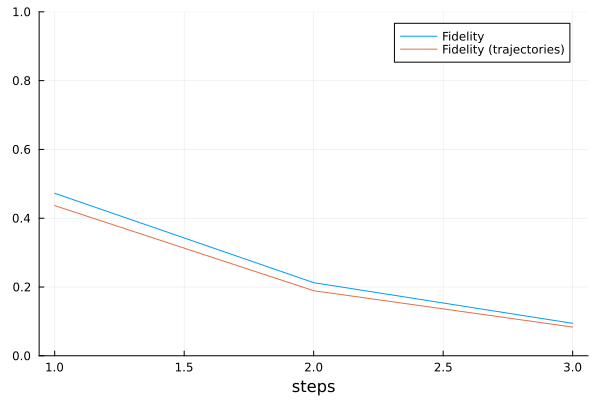

In [7]:
using Plots
plot(1:steps,Fidelity,label="Fidelity")
plot!(1:steps,Fidelity_traj,label="Fidelity (trajectories)")
ylims!((0,1))
xlabel!("steps")